# Practical assignment 5
#### Group 8: Christopher Galias (s1009417) and Robin de Heer (s4349792)

### 1. Run the code and plot the cumulative reward over time.

Import of necessary libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

Environment definition.

In [2]:
class EvidenceEnv(object):
    """
    Very simple task which only requires evaluating present evidence and does not require evidence integration.
    The actor gets a reward when it correctly decides on the ground truth. Ground truth 0/1 determines probabilistically
    the number of 0s or 1s as observations
    """

    def __init__(self, n=1, p=0.8):
        """

        Args:
            n: number of inputs (pieces of evidence)
            p: probability of emitting the right sensation at the input
        """
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
        self.n_input = n
        self.p = p
        self.n_action = 2

        self._state = None

    def reset(self):
        """
        Resets state and generates new observations

        Returns:
            observation
        """

        # generate state
        self._state = np.random.choice(2)

        return self.observe()

    def step(self, action):
        """
        Executes action, updates state and returns an observation, reward, done (episodic tasks) and optional information

        :param action:
        :return: observation, reward, done, info
        """

        # return 1 for correct decision and -1 for incorrect decision
        reward = (2 * (action == self._state) - 1)

        # generate state
        self._state = np.random.choice(2)

        # we are always done after each decision
        done = True

        return self.observe(), reward, done, None

    def observe(self):
        """
        Helper function which generates an observation based on a state

        :return: observation
        """

        # generate associated observations
        P = [self.p, 1 - self.p] if self._state == 0 else [1 - self.p, self.p]

        return np.random.choice(2, self.n_input, True, P).astype('float32').reshape([1, self.n_input])[0]

    def render(self):
        """
        Takes care of rendering

        :return:
        """

        print(self._state)

    def close(self):
        """
        Closes the rendering

        :return:
        """
        pass

    def asint(self,obs):
        """
        Represent input observations as an integer number
        :param obs:
        :return:
        """
        
        return int(sum(2**i*b for i, b in enumerate(obs)))

    def asbinary(self, i, b_len):
        """
        Represent integer as binary array
        :param i: integer
        :param b_len: length of binary array
        :return:
        """

        # get binary representation from integer
        _b = [int(x) for x in list('{0:0b}'.format(i))]
        _b = [0 for i in range(b_len - len(_b))] + _b

        return _b

Definition of the random agent.

In [3]:
class RandomAgent(object):
    
    def __init__(self, env):
        """
        Args:
        env: an environment
        """
        
        self.env = env

    def act(self, observation):
        """
        Act based on observation and train agent on cumulated 
        reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; 
        :None indicates no reward because of initial state
        :return: action (Variable)
        """
        
        return np.random.choice(self.env.n_action)
    
    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        
        pass

Helper training function.

In [4]:
def train(env, agent, n_iter):
    obs = env.reset()  # reset environment and agent
    reward = None
    done = False
    R = []
    for step in range(n_iter):
        # env.render()
        action = agent.act(obs)
        _obs, reward, done, _ = env.step(action)
        agent.train(action, obs, reward, _obs)
        obs = _obs
        R.append(reward)
    return R

Setup of environment and training hyperparameter.

In [5]:
env = EvidenceEnv(n=2, p=0.95)
n_iter = 1000

Setup and "training" of random agent.

In [6]:
random_agent = RandomAgent(env)
random_rewards = train(env, random_agent, n_iter)

Plot of cumulative rewards for the random agent.

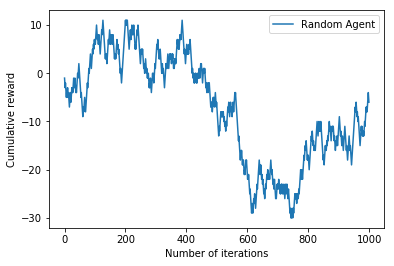

In [7]:
plt.plot(np.cumsum(random_rewards))
plt.legend(["Random Agent"])
plt.ylabel("Cumulative reward")
_ = plt.xlabel("Number of iterations")

### 2. Implement the Tabular Q-learning algorithm and show that your TabularQAgent learns to accumulate reward over time. Plot the cumulative rewards for this agent. Also plot the values for Q(s, a) before and after learning. Note that the state can be represented by converting the binary observations into an integer number. You may use the function EvidenceEnv.asint(obs) for this. Your task is to implement the act and train functions.

More hyperparameters.

In [8]:
alpha = 0.1
gamma = 0.9
epsilon = 0.1

Definition of the tabular Q-agent.

In [9]:
class TabularQAgent(object):
    
    def __init__(self, env, alpha, gamma, eps):
        """
        Args:
        env: an environment
        """
        
        self.env = env
        self.Q = np.random.randn(4, 2)  # (states, actions)
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
    def act(self, obs):
        """
        Act based on observation and train agent on cumulated 
        reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; 
        :None indicates no reward because of initial state
        :return: action (Variable)
        """
        
        if np.random.random() < self.eps:
            return np.random.choice(self.env.n_action)
        else:
            current_state = self.env.asint(obs)
            return 0 if self.Q[current_state, 0] > self.Q[current_state, 1] else 1
            
    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """

        old_state = self.env.asint(old_obs)
        new_state = self.env.asint(new_obs)
        self.Q[old_state, a] += self.alpha * (r + self.gamma * np.max(self.Q[new_state, :]) \
                                              - self.Q[old_state, a])

Setup and training for the tabular Q-agent.

In [10]:
tabular_agent = TabularQAgent(env, alpha, gamma, epsilon)
start_Q_tabular = np.copy(tabular_agent.Q)
tabular_rewards = train(env, tabular_agent, n_iter)
end_Q_tabular = tabular_agent.Q

Plot of cumulative rewards for the two agents.

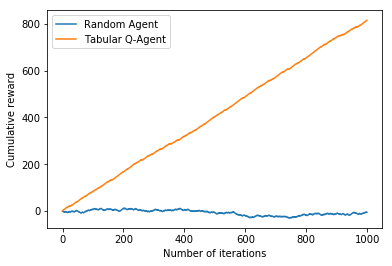

In [11]:
plt.plot(np.cumsum(random_rewards))
plt.plot(np.cumsum(tabular_rewards))
plt.legend(["Random Agent", "Tabular Q-Agent"])
plt.ylabel("Cumulative reward")
_ = plt.xlabel("Number of iterations")

Plot of Q-values before and after learning.

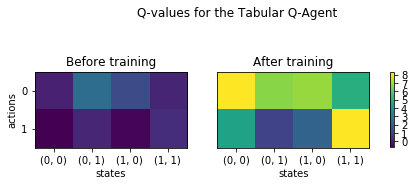

In [12]:
Q_max = np.maximum(np.max(start_Q_tabular), np.max(end_Q_tabular))
Q_min = np.minimum(np.min(start_Q_tabular), np.min(end_Q_tabular))

fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
plt.suptitle("Q-values for the Tabular Q-Agent")

axes[0].set_title("Before training")
axes[0].set_xlabel("states")
axes[0].set_xticklabels(["", (0, 0), (0, 1), (1, 0), (1, 1)])
axes[0].set_ylabel("actions")
axes[0].imshow(start_Q_tabular.T, vmin=Q_min, vmax=Q_max)

axes[1].set_title("After training")
axes[1].set_xlabel("states")
axes[1].set_xticklabels(["", (0, 0), (0, 1), (1, 0), (1, 1)])
axes[1].set_yticks([])
im = axes[1].imshow(end_Q_tabular.T, vmin=Q_min, vmax=Q_max)

_ = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.46)

### 3. Implement a NeuralQAgent in chainer which uses an MLP that takes observations and learns to compute the Q value for all possible actions. Use backpropagation to train your network. Plot the cumulative rewards for this agent. Also plot the values for Q(s, a) before and after learning. You may use the function EvidenceEnv.asbinary(I, b_len) for this.

Import of necessary libraries.

In [13]:
import chainer
from chainer import Variable
from chainer import Chain
import chainer.functions as F
import chainer.links as L

More hyperparameters.

In [14]:
alpha = 0.1
gamma = 0.9
epsilon = 0.1
n_units = 10

Definition of the neural network for computing Q-values.

In [15]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)
            self.l2 = L.Linear(None, n_out)

    def __call__(self, x):
        h = F.tanh(self.l1(x))
        return self.l2(h)

Definition of the neural Q-agent.

In [16]:
class NeuralQAgent(object):
    
    def __init__(self, env, n_units, alpha, gamma, eps):
        """
        Args:
        env: an environment
        """
        
        self.env = env
             
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

        self.model = MLP(n_units, 2)
    
        self.optimizer = chainer.optimizers.SGD(lr=alpha)
        self.optimizer.setup(self.model)
        
    def act(self, obs):
        """
        Act based on observation and train agent on cumulated 
        reward (return)
        :param observation: new observation
        :param reward: reward gained from previous action; 
        :None indicates no reward because of initial state
        :return: action (Variable)
        """
        
        if np.random.random() < self.eps:
            return np.random.choice(self.env.n_action)
        else:
            current_state = np.atleast_2d(obs)
            return 0 if self.model(current_state).data[0, 0] > \
                        self.model(current_state).data[0, 1] else 1
            
    def train(self, a, old_obs, r, new_obs):
        """
        :param a: action
        :param old_obs: old observation
        :param r: reward
        :param new_obs: new observation
        :return:
        """
        
        # chainer wants an additional dummy dimension
        old_state = np.atleast_2d(old_obs)
        new_state = np.atleast_2d(new_obs)

        pred_Q = self.model(old_state)
        
        target_Q = np.copy(pred_Q.data[0, :])
        target_Q[a] = r + gamma * np.max(self.model(new_state).data[0, :])

        target_Q = chainer.Variable(np.atleast_2d(target_Q))
        
        self.model.cleargrads()
        loss = F.mean_squared_error(pred_Q, target_Q)
        loss.backward()
        self.optimizer.update()   

Setup and training for the neural Q-agent.

In [17]:
neural_agent = NeuralQAgent(env, n_units, alpha, gamma, epsilon)
start_Q_neural = np.array(
    [neural_agent.model(np.atleast_2d(env.asbinary(i, 2)).astype('float32')).data[0, :] for i in range(4)])
neural_rewards = train(env, neural_agent, n_iter)
end_Q_neural = np.array(
    [neural_agent.model(np.atleast_2d(env.asbinary(i, 2)).astype('float32')).data[0, :] for i in range(4)])

Plot of cumulative rewards for the three agents.

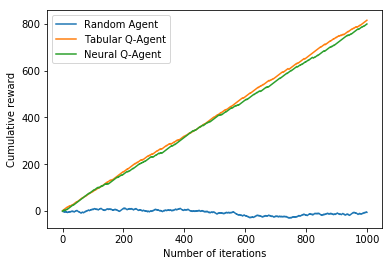

In [18]:
plt.plot(np.cumsum(random_rewards))
plt.plot(np.cumsum(tabular_rewards))
plt.plot(np.cumsum(neural_rewards))
plt.legend(["Random Agent", "Tabular Q-Agent", "Neural Q-Agent"])
plt.ylabel("Cumulative reward")
_ = plt.xlabel("Number of iterations")

Plot of Q-values before and after learning.

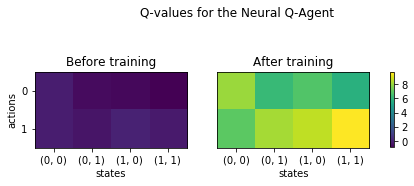

In [19]:
Q_max = np.maximum(np.max(start_Q_neural), np.max(end_Q_neural))
Q_min = np.minimum(np.min(start_Q_neural), np.min(end_Q_neural))

fig, axes = plt.subplots(1, 2, figsize=(7.5, 3))
plt.suptitle("Q-values for the Neural Q-Agent")

axes[0].set_title("Before training")
axes[0].set_xlabel("states")
axes[0].set_xticklabels(["", (0, 0), (0, 1), (1, 0), (1, 1)])
axes[0].set_ylabel("actions")
axes[0].imshow(start_Q_neural.T, vmin=Q_min, vmax=Q_max)

axes[1].set_title("After training")
axes[1].set_xlabel("states")
axes[1].set_xticklabels(["", (0, 0), (0, 1), (1, 0), (1, 1)])
axes[1].set_yticks([])
im = axes[1].imshow(end_Q_neural.T, vmin=Q_min, vmax=Q_max)

_ = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.46)